# Simple Feature Engg Notebook - Spooky Author
https://www.kaggle.com/sudalairajkumar/simple-feature-engg-notebook-spooky-author

__컴피티션의 목적__:

이 컴피티션 데이터는 세 저자가 쓴 소설의 텍스트가 포함되어 있습니다.
1. Edgar Allan Poe (EAP)
2. HP Lovecraft (HPL)
3. Mary Wollstonecraft Shelley (MWS)

테스트 셋 문장의 저자들을 정확히 식별해내는 것이 목표입니다.

__이 노트북의 목적:__

이 노트북에서는 저자들을 식별하는 여러 피쳐들을 만들것입니다.

첫 번째로, 피쳐 엔지니어링을 하기전에 기초적인 데이터 시각화와 데이터 클리닝을 진행합니다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
color = sns.color_palette()

%matplotlib inline

eng_stopwords = set(stopwords.words('english'))
pd.options.mode.chained_assignment = None

Duplicate key in file WindowsPath('C:/ProgramData/Anaconda3/envs/tens_2g/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 258 ('font.size:    10.0')
Duplicate key in file WindowsPath('C:/ProgramData/Anaconda3/envs/tens_2g/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 364 ('axes.titlesize:     large   # fontsize of the axes title')
Duplicate key in file WindowsPath('C:/ProgramData/Anaconda3/envs/tens_2g/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 370 ('axes.labelsize:     medium  # fontsize of the x any y labels')
Duplicate key in file WindowsPath('C:/ProgramData/Anaconda3/envs/tens_2g/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 469 ('xtick.labelsize:     medium  # fontsize of the tick labels')
Duplicate key in file WindowsPath('C:/ProgramData/Anaconda3/envs/tens_2g/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 489 ('ytick.labelsize:     medium  # fontsize of the tick labels')


In [2]:
# 데이터셋 로드
train_df = pd.read_csv('./input/train.csv')
test_df = pd.read_csv('./input/test.csv')
print('Number of rows in train dataset:', train_df.shape[0])
print('Number of rows in test dataset:', test_df.shape[0])

Number of rows in train dataset: 19579
Number of rows in test dataset: 8392


In [3]:
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


각 저자들이 몇번 발생했는지, 분포가 균형을 이루는지 살펴보겠습니다.

C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


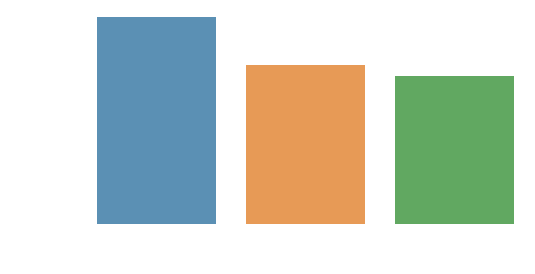

In [4]:
cnt_srs = train_df['author'].value_counts()

plt.figure(figsize=(8, 4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=.8)
plt.ylabel('Number of Occurences', fontsize=12)
plt.xlabel('Author Name', fontsize=12)
plt.show()

괜찮아보입니다. 클래스간 분포가 불균형이긴 하지만 크다고 생각하지는 않습니다. 

이번에는 각 저자들이 어떤 스타일로 글을 쓰는지 알아보도록 하겠습니다.(가능하다면요)

In [5]:
grouped_df = train_df.groupby('author')
for name, group in grouped_df:
    print('Author name:', name)
    cnt = 0
    for ind, row in group.iterrows():
        print(row['text'])
        cnt += 1
        if cnt == 5:
            break
    print('\n')

Author name: EAP
This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.
The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.
The surcingle hung in ribands from my body.
I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony, I felt that you could 

확신할 수 있는 건 텍스트에 몇 가지 특별한 문구가 있다는 것입니다. 따라서 특별한 문구를 카운팅하는 것은 하나의 좋은 피쳐가 될 것 같습니다.

이 외에는 단서가 딱히 없는 것 같습니다.

__Feature Engineering:__

이제 몇 가지 피쳐 엔지니어링을 진행하겠습니다. 이는 두 가지 파트로 구성됩니다.
1. 메타 피쳐: 단어의 수, 중지 단어의 수, 구두점의 수 등 텍스트에서 추출한 피쳐
2. 텍스트 기반 피쳐: 텍스트에 기반한 피쳐들/ 빈도, svd, word2vec 등

__Meta Features:__

첫번째로 메타 피쳐를 만들어 저자를 얼마나 예측할 수 있는지 살펴보겠습니다.

다음과 같은 피쳐를 만들어보겠습니다.
1. 텍스트의 단어 수
2. 텍스트의 단어 수 (중복 제거)
3. 텍스트의 문자 수
4. 텍스트의 중지단어 수
5. 텍스트의 구두점 수
6. 텍스트의 대소문자의 수
7. 제목의 단어 수
8. 단어의 평균 길이

In [6]:
## 단어 수 
train_df['num_words'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df['num_words'] = test_df['text'].apply(lambda x: len(str(x).split()))

## 단어 수(중복 제거)
train_df['num_unique_words'] = train_df['text'].apply(lambda x: len(set(str(x).split())))
test_df['num_unique_words'] = test_df['text'].apply(lambda x: len(set(str(x).split())))

## 문자 수
train_df['num_chars'] = train_df['text'].apply(lambda x: len(str(x)))
test_df['num_chars'] = test_df['text'].apply(lambda x: len(str(x)))

## 중지단어 수
train_df['num_stopwords'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df['num_stopwords'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## 구두점 수
train_df['num_punctuations'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_df['num_punctuations'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

## 대소문자 수
train_df['num_words_upper'] = train_df['text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df['num_words_upper'] = test_df['text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## 제목의 단어 수
train_df['num_words_title'] = train_df['text'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df['num_words_title'] = test_df['text'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## 평균 단어 길이
train_df['mean_word_len'] = train_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_len'] = test_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

그래프를 그려 새로운 변수들이 예측에 얼마나 도움이 되는지 살펴봅니다

Text(0.5, 1.0, 'Num of words by author')

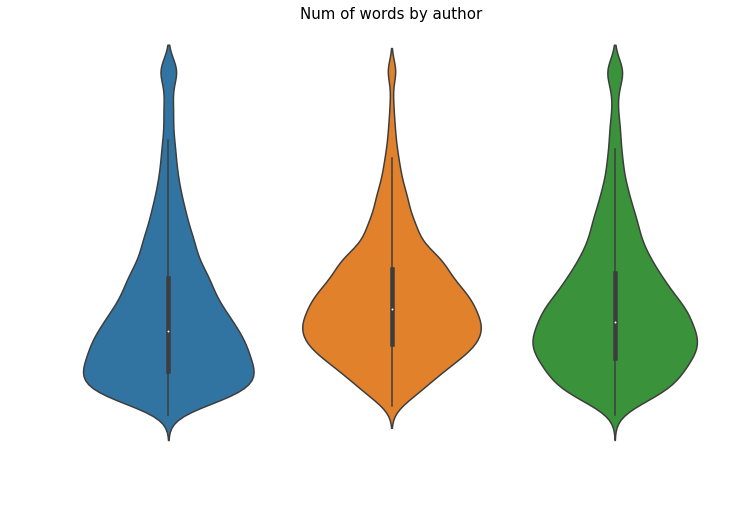

In [7]:
train_df['num_words'].loc[train_df['num_words']>80] = 80 # 더 나은 그림을 위해 절삭
plt.figure(figsize=(12, 8))
sns.violinplot(x='author', y='num_words', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Num of words in text', fontsize=12)
plt.title('Num of words by author', fontsize=15)

EAP는 MWS와 HPL보다 단어 수가 조금 더 적은 것 같습니다.

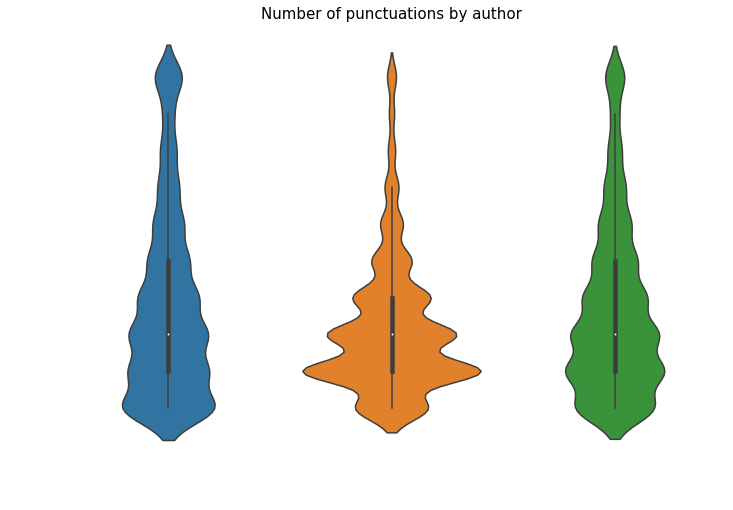

In [8]:
train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 10 # 더 나은 그림을 위해 절삭
plt.figure(figsize=(12, 8))
sns.violinplot(x='author', y='num_punctuations', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of punctuations in text', fontsize=12)
plt.title('Number of punctuations by author', fontsize=15)
plt.show()

위 그림도 유용해 보입니다. 이제 텍스트 기반 피쳐를 만드는데 집중해보겠습니다.

첫번째로 메타 피쳐가 얼마나 도움되는지 알아보기 위해 기초 모델을 만들겠습니다.

In [9]:
# 모델링을 위한 데이터 준비
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS': 2}
train_y = train_df['author'].map(author_mapping_dict)
train_id = train_df['id'].values
test_id = test_df['id'].values

# 절삭된 변수를 다시 계산
train_df['num_words'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df['num_words'] = test_df['text'].apply(lambda x: len(str(x).split()))
train_df['mean_word_len'] = train_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_len'] = test_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

간단한 XGBoost 모델을 메타 피쳐만 가지고 훈련시키겠습니다.

In [10]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = 'mlogloss'
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000
    
    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    
    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [(xgtrain, 'train'), (xgtest, 'test')]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, 
                          early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)
        
    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit=model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

K폴드 교차 검증을 이용해 점수를 확인해보겠습니다.

In [11]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print('cv scores: ', cv_scores)
print('mean cv scores: ', np.mean(cv_scores))

[0]	train-mlogloss:1.0937	test-mlogloss:1.09453
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:1.04138	test-mlogloss:1.05172
[40]	train-mlogloss:1.02343	test-mlogloss:1.03983
[60]	train-mlogloss:1.01043	test-mlogloss:1.03051
[80]	train-mlogloss:1.00001	test-mlogloss:1.02301
[100]	train-mlogloss:0.992055	test-mlogloss:1.01754
[120]	train-mlogloss:0.983985	test-mlogloss:1.01192
[140]	train-mlogloss:0.977471	test-mlogloss:1.00829
[160]	train-mlogloss:0.972333	test-mlogloss:1.00502
[180]	train-mlogloss:0.967121	test-mlogloss:1.00192
[200]	train-mlogloss:0.962842	test-mlogloss:1.00031
[220]	train-mlogloss:0.959004	test-mlogloss:0.999193
[240]	train-mlogloss:0.954595	test-mlogloss:0.997093
[260]	train-mlogloss:0.951285	test-mlogloss:0.99559
[280]	train-mlogloss:0.948092	test-mlogloss:0.994533
[300]	train-mlogloss:0.945068	test-mlogloss:0.993918
[320]	train-mlogloss:0.94

[440]	train-mlogloss:0.92851	test-mlogloss:0.976908
[460]	train-mlogloss:0.926456	test-mlogloss:0.976528
[480]	train-mlogloss:0.924516	test-mlogloss:0.976376
[500]	train-mlogloss:0.922497	test-mlogloss:0.976512
[520]	train-mlogloss:0.92046	test-mlogloss:0.976071
[540]	train-mlogloss:0.918701	test-mlogloss:0.976173
[560]	train-mlogloss:0.917222	test-mlogloss:0.975728
[580]	train-mlogloss:0.91564	test-mlogloss:0.975558
[600]	train-mlogloss:0.914033	test-mlogloss:0.975636
[620]	train-mlogloss:0.91249	test-mlogloss:0.975745
[640]	train-mlogloss:0.91108	test-mlogloss:0.975857
Stopping. Best iteration:
[594]	train-mlogloss:0.914425	test-mlogloss:0.975509

cv scores:  [0.9897508602127988, 0.97780218520568, 0.9903498525446827, 0.9839140649445439, 0.9755093023490213]
mean cv scores:  0.9834652530513454


메타 피쳐를 이용했을 때 mlogloss가 0.983이 나왔습니다. 이번에는 피쳐중요도를 살펴보겠습니다.

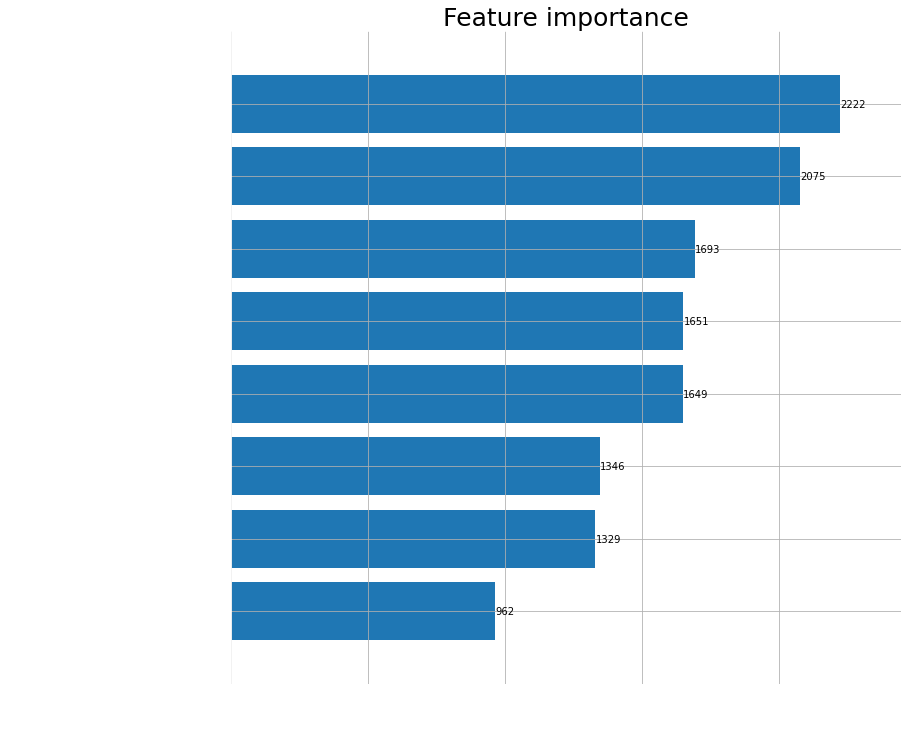

In [12]:
# 중요 변수 그림
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

평균 단어 길이, 문자 수, 단어 수가 top3에 들었습니다. 이제 텍스트 기반 피쳐에 대해 살펴보겠습니다.

__Text Based Features__:

우리가 만들 수 있는 기본적인 피쳐중 하나는 텍스트에 있는 단어의 tf-idf 값입니다.

In [13]:
# tfidf 벡터라이저를 사용해 변환
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

tfidf을 얻었지만 유의해야할 부분이 있습니다. tfidf 결과물은 희소행렬이라 조밀한 피쳐와 사용해야 한다면 몇 가지 선택사항이 있습니다.

1. tfidf 벡터라이저에서 상위 n개의 피쳐를 선택하여 조밀한 형식으로 변환한 뒤 다른 피쳐와 합칩니다.
2. 희소 피쳐로 모델을 구성하고 예측을 다른 조밀한 피쳐들과 함께 피쳐 중 하나로 사용합니다.

데이터셋에 따라 두 가지가 뭐가 좋은지 달라집니다. tfidf의 모든 피쳐들을 사용하여 점수를 매길 수 있는 여러 커널들이 있기 때문에 여기서는 두번째 방식을 사용하겠습니다.

또한 나이브 베이즈도 잘 작동합니다. 따라서 tfidf 피쳐를 사용하여 나이브 베이즈 모델을 구축하는 것도 좋습니다.

In [14]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

In [15]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print('Mean cv score:', np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score: 0.8422161983612853


tfidf만을 사용하여 0.844의 mlogloss를 얻었습니다. 메타 피쳐보다 좋은 점수입니다. 컨퓨전 매트릭스를 살펴보겠습니다.

In [16]:
# 컨퓨전 매트릭스 생성 함수
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

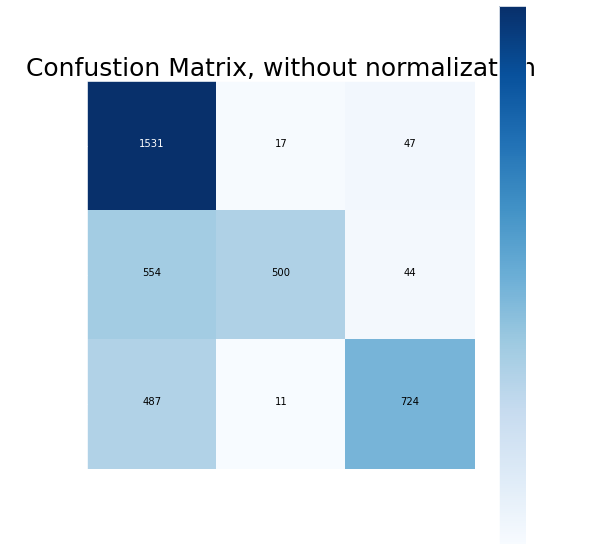

In [17]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y, axis=1))
np.set_printoptions(precision=2)

# 정규화되지 않은 컨퓨전 매트릭스 그림
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confustion Matrix, without normalization')
plt.show()

많은 인스턴스들이 EAP로 예측되고 그 클래스에 매우 편향되어 있습니다.
__SVD on word TFIDF:__

tfidf 벡터가 매우 희소하기 때문에, 정보를 압축하고 나타내는 컴팩트한 방법 중 하나는 SVD입니다. 따라서 svd 피쳐를 만들어 추가하겠습니다.

In [18]:
n_comp = 20
svd_obj = TruncatedSVD(n_components = n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_word_' + str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_' + str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

__나이브 베이즈 단어 카운트 벡터라이저:__

In [19]:
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1, 3))
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

피쳐 기반 카운트 벡터라이저를 사용하여 다항 NB 모델을 구축하겠습니다.

In [20]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print('Mean cv score:', np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# 예측을 새로운 피쳐로 추가
train_df['nb_cvec_eap'] = pred_train[:,0]
train_df['nb_cvec_hpl'] = pred_train[:,1]
train_df['nb_cvec_mws'] = pred_train[:,2]
test_df['nb_cvec_eap'] = pred_full_test[:,0]
test_df['nb_cvec_hpl'] = pred_full_test[:,1]
test_df['nb_cvec_mws'] = pred_full_test[:,2]


Mean cv score: 0.4509184161656747


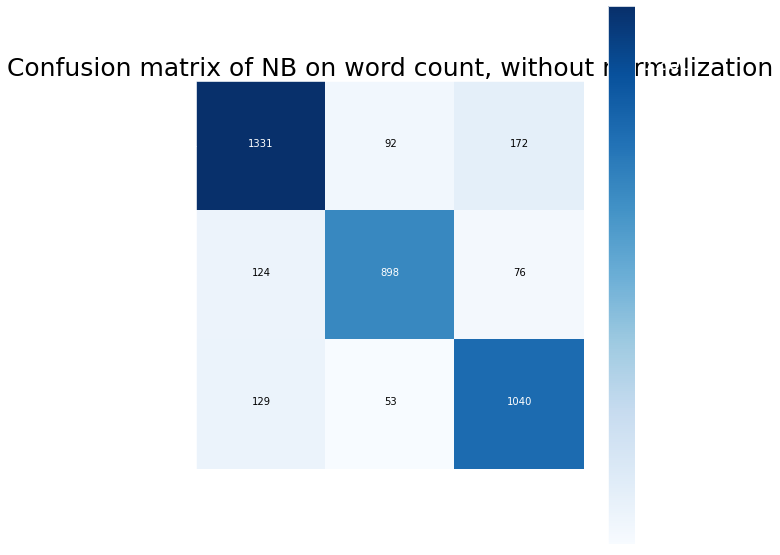

In [21]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# 정규화되지 않은 컨퓨전 매트릭스 그림
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of NB on word count, without normalization')
plt.show()

교차검증 mlogloss가 약 0.451이 나왔습니다. 또한 컨퓨전 매트릭스가 이전 보다 훨씬 나아 보입니다.

__Naive Bayes on Character Count Vectorizer:__

데이터를 바라보는 한 가지 아이디어는 특수 문자를 세는 것입니다. 특수 문자만 세는 대신 문자 수준의 CountVectorizer을 사용하여 몇 가지 피쳐를 얻을 수 있고, 여기에 다항 NB를 적용할 수 있습니다.

In [22]:
tfidf_vec = CountVectorizer(ngram_range=(1,7), analyzer='char')
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print('Mean cv score:', np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# 예측을 새로운 피쳐로 추가
train_df['nb_cvec_char_eap'] = pred_train[:, 0]
train_df['nb_cvec_char_hpl'] = pred_train[:, 1]
train_df['nb_cvec_char_mws'] = pred_train[:, 2]
test_df['nb_cvec_char_eap'] = pred_full_test[:, 0]
test_df['nb_cvec_char_hpl'] = pred_full_test[:, 1]
test_df['nb_cvec_char_mws'] = pred_full_test[:, 2]

Mean cv score: 3.750763922681903


 교차 점수가 매우 높게 나왔습니다. 그러나 단어 수준의 피처와는 다른 정보를 추가할 수 있으므로 최종 모델에 고려할 수 있습니다.
 
 __Naive Bayes on Character Tfidf Vectorizer:__
 tfidf 벡터라이저의 문자에 대한 나이브 베이즈 예측을 해보겠습니다.

In [24]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print('Mean cv score:', np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

train_df['nb_tfidf_char_eap'] = pred_train[:, 0]
train_df['nb_tfidf_char_hpl'] = pred_train[:, 1]
train_df['nb_tfidf_char_mws'] = pred_train[:, 2]
test_df['nb_tfidf_char_eap'] = pred_full_test[:, 0]
test_df['nb_tfidf_char_hpl'] = pred_full_test[:, 1]
test_df['nb_tfidf_char_mws'] = pred_full_test[:, 2]

Mean cv score: 0.7904152589474216


__SVD on Character TFIDF:__

또한 문자 TFIDF 기능에 SVD 피쳐를 생성하여 모델링에 사용할 수도 있습니다.

In [25]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_char_' + str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_' + str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

__XGBoost model:__

새 변수들로 xgboost 모델을 다시 실행시키고 결과를 평가합니다.

In [28]:
cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print('cv scores:', cv_scores)
print('mean cv scores:', np.mean(cv_scores))
out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv('sub_fe.csv', index=False)

[0]	train-mlogloss:1.00261	test-mlogloss:1.00252
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.411208	test-mlogloss:0.416123
[40]	train-mlogloss:0.340595	test-mlogloss:0.353123
[60]	train-mlogloss:0.317139	test-mlogloss:0.336646
[80]	train-mlogloss:0.300647	test-mlogloss:0.327143
[100]	train-mlogloss:0.287083	test-mlogloss:0.320742
[120]	train-mlogloss:0.275909	test-mlogloss:0.316093
[140]	train-mlogloss:0.26582	test-mlogloss:0.313793
[160]	train-mlogloss:0.257669	test-mlogloss:0.312049
[180]	train-mlogloss:0.249599	test-mlogloss:0.310797
[200]	train-mlogloss:0.242103	test-mlogloss:0.309073
[220]	train-mlogloss:0.235175	test-mlogloss:0.307382
[240]	train-mlogloss:0.22828	test-mlogloss:0.306606
[260]	train-mlogloss:0.222457	test-mlogloss:0.306277
[280]	train-mlogloss:0.216763	test-mlogloss:0.306058
[300]	train-mlogloss:0.210979	test-mlogloss:0.306152
[320]	train

평균 cv 점수가 0.3100이 나왔습니다. 이제 중요 변수들을 다시 한번 확인해 보겠습니다.

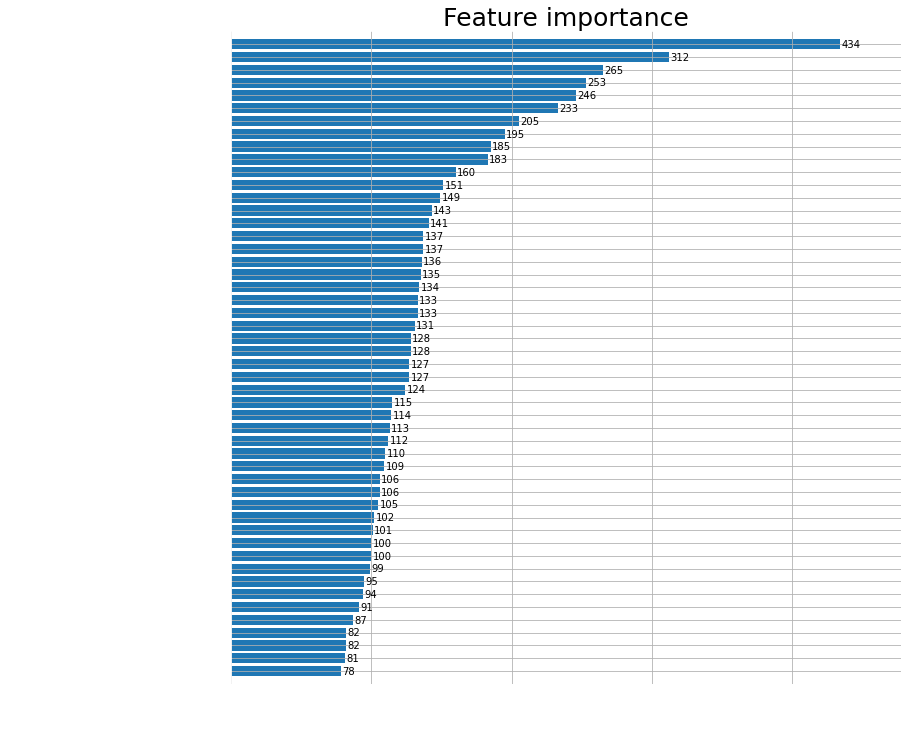

In [29]:
# 중요 변수 그림
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

나이브 베이즈 피처가 최상위에 있습니다. 이제 컨퓨전 매트릭스를 통해 오분류 오류를 살펴봅니다.

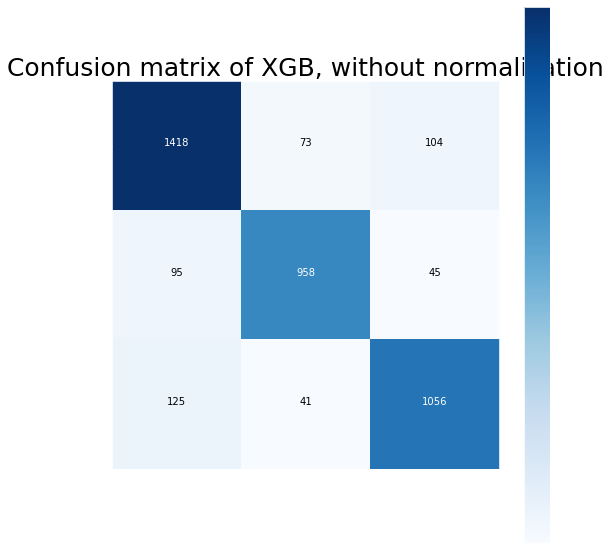

In [31]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y, axis=1))
np.set_printoptions(precision=2)

# 정규화 되지 않은 컨퓨전 매트릭스
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of XGB, without normalization')